In [1]:
import geopandas as gpd
import itertools as itr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

matplotlib.style.use('ggplot')

### Collate Feature Data

In [2]:
tjhd_df = pd.read_csv('other_data/TJHD_ZCTAs.txt') \
            .set_index(keys=['ZCTA'])

In [3]:
def add_area_variable(tjhd_df):
    """Returns the tjhd_df dataframe with an 'Area' column
    added to the dataframe.
    The 'Area' column contains the area of the ZCTA (miles
    squared).
    """
    # A geopandas GeoDataFrame of the Zip Code Tabulation Areas of interest.
    zctas_gdf = gpd.read_file('GIS_data/TJHD_ZCTAs/TJHD_ZCTAs.shp')
    zctas_gdf = zctas_gdf.set_index(zctas_gdf['ZCTA5CE10'].astype('int'))

    # Re-project to Equal Area Projection. See comment by Swier here:
    # https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas
    zctas_gdf = zctas_gdf.to_crs({'proj': 'cea'})

    # This computes the area in meters squared, and then uses the conversion
    # factor to get it to miles squared
    zctas_gdf['Area'] = zctas_gdf.area * (3.86102 * (10**(-7)))

    return tjhd_df.join(zctas_gdf['Area'], how='left')


tjhd_df = add_area_variable(tjhd_df)

In [4]:
# These values are taken from the .txt files that accompany the ACS file downloads
acs_na_values = ['-', '+', '***', '****', 'N', '(X)']

In [5]:
def add_population_age_sex_variables(tjhd_df):
    """Returns the tjhd_df dataframe with five 'Age_CatX_Pct' 
    columns (where X can be [0, 1, 2, 3, 4]), a 'Male_Cnt' 
    column, a 'Female_Cnt' column, and a 'Population_Cnt'
    column added to the dataframe.
    The 'Age_CatX_Pct' columns contain the estimated percentage 
    of the ZCTA population that falls into the indexed age category,
    the 'Male' column contains the estimated number of males
    in the ZCTA, the 'Female' column contains the estimated
    number of females in the ZCTA, and the 'Population_Cnt' 
    column contains the estimated population of the ZCTA.
    """
    # S0101: AGE AND SEX
    df_age_sex = pd.read_csv('ACS_data/age_sex/ACS_16_5YR_S0101_with_ann.csv', 
                             skiprows=[1],
                             na_values=acs_na_values).set_index('GEO.id2')

    # Cat0: Under 5 years of age
    df_age_sex['Age_Cat0_Pct'] = df_age_sex['HC01_EST_VC03']

    # Cat1: 5 - 19 years of age
    df_age_sex['Age_Cat1_Pct'] = df_age_sex['HC01_EST_VC04'] + df_age_sex['HC01_EST_VC05'] + df_age_sex['HC01_EST_VC06']

    # Cat2: 20 - 44 years of age
    df_age_sex['Age_Cat2_Pct'] = 0
    for idx in range(7, 12):
        df_age_sex['Age_Cat2_Pct'] += df_age_sex['HC01_EST_VC%s' % str(idx).zfill(2)]

    # Cat3: 45 - 69 years of age
    df_age_sex['Age_Cat3_Pct'] = 0
    for idx in range(12, 17):
        df_age_sex['Age_Cat3_Pct'] += df_age_sex['HC01_EST_VC%s' % str(idx).zfill(2)]

    # Cat4: 70 years of age and older
    df_age_sex['Age_Cat4_Pct'] = 0
    for idx in range(17, 21):
        df_age_sex['Age_Cat4_Pct'] += df_age_sex['HC01_EST_VC%s' % str(idx).zfill(2)]
        
    # Child: Under 20 years of age
    df_age_sex['Age_Child_Pct'] = 0
    for idx in range(3, 7):
        df_age_sex['Age_Child_Pct'] += df_age_sex['HC01_EST_VC%s' % str(idx).zfill(2)]

    # Adult: 20 - 64 years of age
    df_age_sex['Age_Adult_Pct'] = 0
    for idx in range(7, 16):
        df_age_sex['Age_Adult_Pct'] += df_age_sex['HC01_EST_VC%s' % str(idx).zfill(2)]

    # Retired: 65 years of age and older
    df_age_sex['Age_Retired_Pct'] = 0
    for idx in range(16, 21):
        df_age_sex['Age_Retired_Pct'] += df_age_sex['HC01_EST_VC%s' % str(idx).zfill(2)]

    df_age_sex['Population_Cnt'] = df_age_sex['HC01_EST_VC01']
    df_age_sex['Male_Cnt'] = df_age_sex['HC02_EST_VC01']
    df_age_sex['Female_Cnt'] = df_age_sex['HC03_EST_VC01']

    column_names = ['Age_Cat0_Pct', 'Age_Cat1_Pct', 'Age_Cat2_Pct', 'Age_Cat3_Pct', 'Age_Cat4_Pct',
                    'Age_Child_Pct', 'Age_Adult_Pct', 'Age_Retired_Pct',
                    'Population_Cnt', 'Male_Cnt', 'Female_Cnt']
    return tjhd_df.join(df_age_sex[column_names], how='left')


tjhd_df = add_population_age_sex_variables(tjhd_df)

In [6]:
def add_household_income_variables(tjhd_df):
    """Returns the tjhd_df dataframe with three 'Inc_CatX_Pct'
    columns (where X can be [0, 1, 2]), and a 'Median_HH_Inc' 
    column.
    The 'Inc_CatX_Pct' columns contain the percentage of the 
    ZCTA population that falls into the indexed income category, 
    and the 'Median_HH_Inc' column contains the median household
    income of the ZCTA population.
    """
    # S1901: INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS)
    df_hh_inc = pd.read_csv('ACS_data/household_income/ACS_16_5YR_S1901_with_ann.csv', 
                            skiprows=[1],
                            na_values=acs_na_values).set_index('GEO.id2')

    # Cat_0: < $25,000
    df_hh_inc['Inc_Cat0_Pct'] = 0
    for idx in range(2, 5):
        df_hh_inc['Inc_Cat0_Pct'] += df_hh_inc['HC01_EST_VC%s' % str(idx).zfill(2)]

    # Cat_1: >= $25,000 AND < $100,000
    df_hh_inc['Inc_Cat1_Pct'] = 0
    for idx in range(5, 9):
        df_hh_inc['Inc_Cat1_Pct'] += df_hh_inc['HC01_EST_VC%s' % str(idx).zfill(2)]

    # Cat_2: >= $100,000
    df_hh_inc['Inc_Cat2_Pct'] = 0
    for idx in range(9, 12):
        df_hh_inc['Inc_Cat2_Pct'] += df_hh_inc['HC01_EST_VC%s' % str(idx).zfill(2)]

    df_hh_inc['Median_HH_Inc'] = df_hh_inc['HC01_EST_VC13']
    df_hh_inc['Mean_HH_Inc'] = df_hh_inc['HC01_EST_VC15']

    return tjhd_df.join(df_hh_inc[['Inc_Cat0_Pct', 'Inc_Cat1_Pct', 'Inc_Cat2_Pct', 
                                   'Median_HH_Inc', 'Mean_HH_Inc']],
                        how='left')


tjhd_df = add_household_income_variables(tjhd_df)

In [7]:
def add_educational_attainment_variables(tjhd_df):
    """Returns the tjhd_df dataframe with a 'HSchool_Plus_Pct'
    column and a 'Bachelor_Plus_Pct' column added to the 
    dataframe.
    The 'HSchool_Plus_Pct' column contains the percentage of
    the population in the ZCTA with a high school degree or 
    higher level of education, and the 'Bachelor_Plus_Pct' 
    column contains the percentage of the population in the 
    ZCTA with a bachelors degree or higher level of education.
    """
    # S1501: EDUCATIONAL ATTAINMENT
    df_edu_att = pd.read_csv('ACS_data/educational_attainment/ACS_16_5YR_S1501_with_ann.csv', 
                             skiprows=[1],
                             na_values=acs_na_values).set_index('GEO.id2')

    df_edu_att['HSchool_Plus_Pct'] = df_edu_att['HC02_EST_VC17']
    df_edu_att['Bachelor_Plus_Pct'] = df_edu_att['HC02_EST_VC18']

    return tjhd_df.join(df_edu_att[['HSchool_Plus_Pct', 'Bachelor_Plus_Pct']], how='left')


tjhd_df = add_educational_attainment_variables(tjhd_df)

In [8]:
def add_race_variables(tjhd_df):
    """Returns the tjhd_df dataframe with a 'White_Pct' column,
    a 'Black_Pct' column, an 'Asian_Pct' column, and a 
    'Hispanic_Pct' column added to the dataframe.
    The 'White_Pct' column contains the percentage of the ZCTA 
    population that identifies as non-hispanic and white alone, 
    the 'Black_Pct' column contains the percentage of the ZCTA
    population that identifies as non-hispanic and black alone, 
    the 'Asian_Pct' column contains the percentage of the ZCTA 
    population that identifies as non-hispanic and asian alone, 
    and the 'Hispanic_Pct' identifies the percentage of the 
    population that identifies as hispanic (not necessarily 
    hispanic alone, e.g. hispanic and white).
    """
    # B03002: HISPANIC OR LATINO ORIGIN BY RACE
    # Universe: Total population
    df_race = pd.read_csv('ACS_data/race/ACS_16_5YR_B03002_with_ann.csv', 
                          skiprows=[1],
                          na_values=acs_na_values).set_index('GEO.id2')

    df_race['White_Pct'] = 100.0 * df_race['HD01_VD03'] / df_race['HD01_VD01']
    df_race['Black_Pct'] = 100.0 * df_race['HD01_VD04'] / df_race['HD01_VD01']
    df_race['Asian_Pct'] = 100.0 * df_race['HD01_VD06'] / df_race['HD01_VD01']
    df_race['Hispanic_Pct'] = 100.0 * df_race['HD01_VD12'] / df_race['HD01_VD01']

    return tjhd_df.join(df_race[['White_Pct', 'Black_Pct', 'Asian_Pct', 'Hispanic_Pct']], how='left')


tjhd_df = add_race_variables(tjhd_df)

In [9]:
def add_rent_variables(tjhd_df):
    """Returns the tjhd_df dataframe with an 'Owner_Occupied_Pct'
    column, and a 'Renter_Occupied_Pct' column added to the 
    dataframe.
    The 'Owner_Occupied_Pct' column is the percentage of 
    households in the ZCTA that are owner occupied, and the 
    'Renter_Occupied_Pct' column is the percentage of 
    households in the ZCTA that are renter occupied.    
    """
    # B25118: TENURE BY HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS)
    # Universe: Occupied housing units
    df_rent_own = pd.read_csv('ACS_data/rent_own_house/ACS_16_5YR_B25118_with_ann.csv', 
                              skiprows=[1],
                              na_values=acs_na_values).set_index('GEO.id2')

    df_rent_own['Owner_Occupied_Pct'] = 100.0 * df_rent_own['HD01_VD02'] / df_rent_own['HD01_VD01']
    df_rent_own['Renter_Occupied_Pct'] = 100.0 * df_rent_own['HD01_VD14'] / df_rent_own['HD01_VD01']

    return tjhd_df.join(df_rent_own[['Owner_Occupied_Pct', 'Renter_Occupied_Pct']], how='left')


tjhd_df = add_rent_variables(tjhd_df)

In [10]:
def add_urban_rural_variables(tjhd_df):
    """Returns a dataframe with a 'Urban_Pct' column, and
    a 'Rural_Pct' column added to the dataframe.
    The 'Urban_Pct' column is the percentage of the population in the ZCTA
    that is classified as urban, while the 'Rural_Pct' column is the
    percentage of the population in the ZCTA that is classified as rural.
    """
    # P2: URBAN AND RURAL
    # Universe: Total population
    ## NOTE: This file is from the 2010 Census, not the 2016 ACS.
    df_rural_urban = pd.read_csv('ACS_data/rural_urban/DEC_10_SF1_P2_with_ann.csv', 
                                skiprows=[1],
                                na_values=acs_na_values).set_index('GEO.id2')

    df_rural_urban['Urban_Pct'] = 100.0 * df_rural_urban['D002'] / df_rural_urban['D001']
    df_rural_urban['Rural_Pct'] = 100.0 * df_rural_urban['D005'] / df_rural_urban['D001']

    return tjhd_df.join(df_rural_urban[['Urban_Pct', 'Rural_Pct']], how='left')


tjhd_df = add_urban_rural_variables(tjhd_df)

In [11]:
tjhd_df['Population_Density'] = tjhd_df['Population_Cnt'] / tjhd_df['Area']

### Feature Analysis

In [12]:
# Identify feature columns with null values
null_count = tjhd_df.isnull().sum()
print(null_count.loc[null_count > 0])

Median_HH_Inc    2
Mean_HH_Inc      1
dtype: int64


In [13]:
print('Median')
print(tjhd_df.loc[tjhd_df['Median_HH_Inc'].isnull()].index)
print('\nMean')
print(tjhd_df.loc[tjhd_df['Mean_HH_Inc'].isnull()].index)

Median
Int64Index([22904, 24581], dtype='int64', name='ZCTA')

Mean
Int64Index([24581], dtype='int64', name='ZCTA')


In [14]:
# Replace null values in each Feature with the median value
tjhd_df['Median_HH_Inc'].fillna(value=tjhd_df['Median_HH_Inc'].median(), inplace=True)
tjhd_df['Mean_HH_Inc'].fillna(value=tjhd_df['Mean_HH_Inc'].median(), inplace=True)

In [15]:
# Drop unneeded features
for feature in ['Area', 
                'Male_Cnt', 'Female_Cnt', 'Population_Cnt',
                'HSchool_Plus_Pct', 
                'Owner_Occupied_Pct', 'Renter_Occupied_Pct',
                'Urban_Pct']:
    del tjhd_df[feature]
print(tjhd_df.columns)

Index(['Age_Cat0_Pct', 'Age_Cat1_Pct', 'Age_Cat2_Pct', 'Age_Cat3_Pct',
       'Age_Cat4_Pct', 'Age_Child_Pct', 'Age_Adult_Pct', 'Age_Retired_Pct',
       'Inc_Cat0_Pct', 'Inc_Cat1_Pct', 'Inc_Cat2_Pct', 'Median_HH_Inc',
       'Mean_HH_Inc', 'Bachelor_Plus_Pct', 'White_Pct', 'Black_Pct',
       'Asian_Pct', 'Hispanic_Pct', 'Rural_Pct', 'Population_Density'],
      dtype='object')


The transformation (none, sqrt, or log) that produces the most 'normal' looking histogram is chosen for each feature.

In [16]:
# Scott's Rule
# c = (5/3)*( n^{1/3} ) = 7.74 ==> 7 or 8 bins for n = 100
num_bins = int((5 / 3.0) * (tjhd_df.shape[0]**(1 / 3.0)) + 0.5)

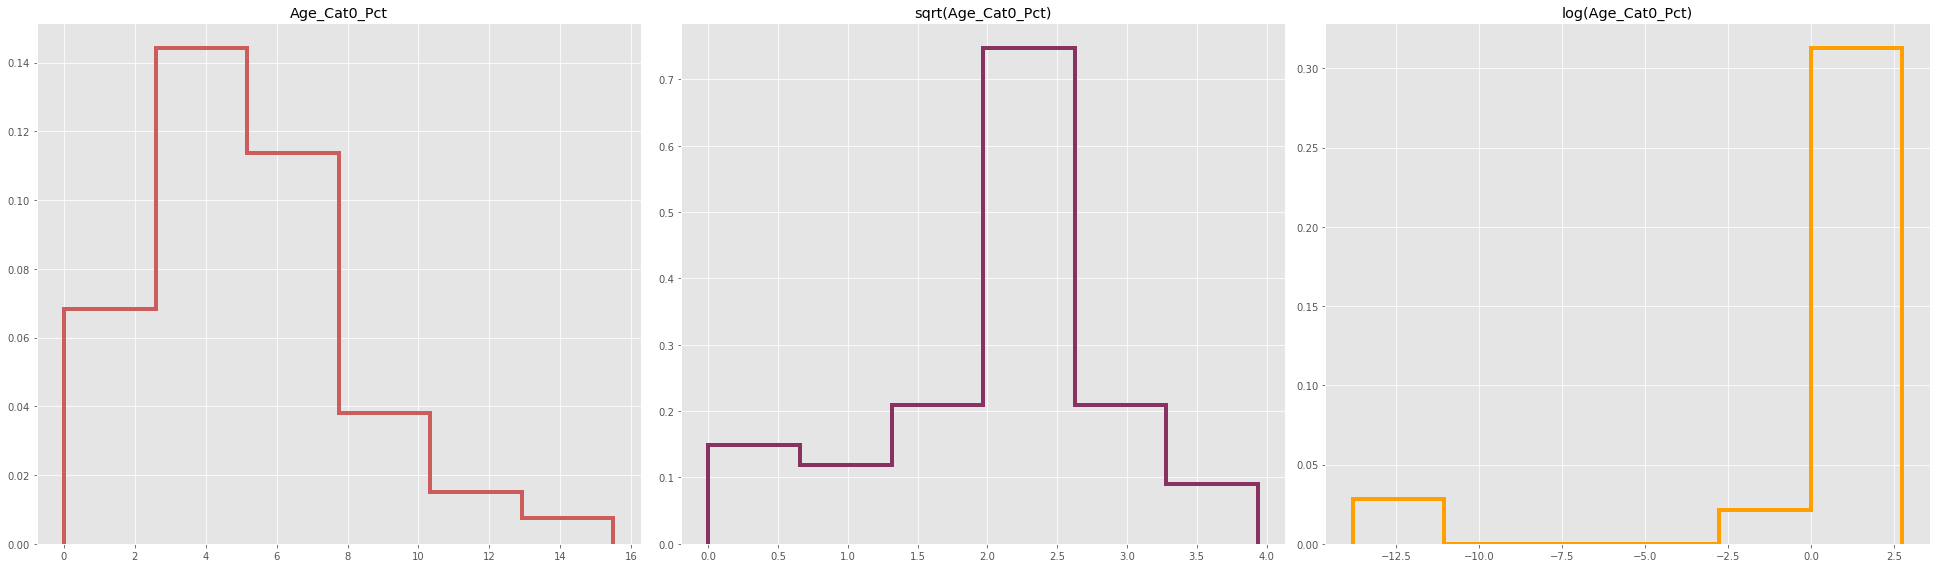

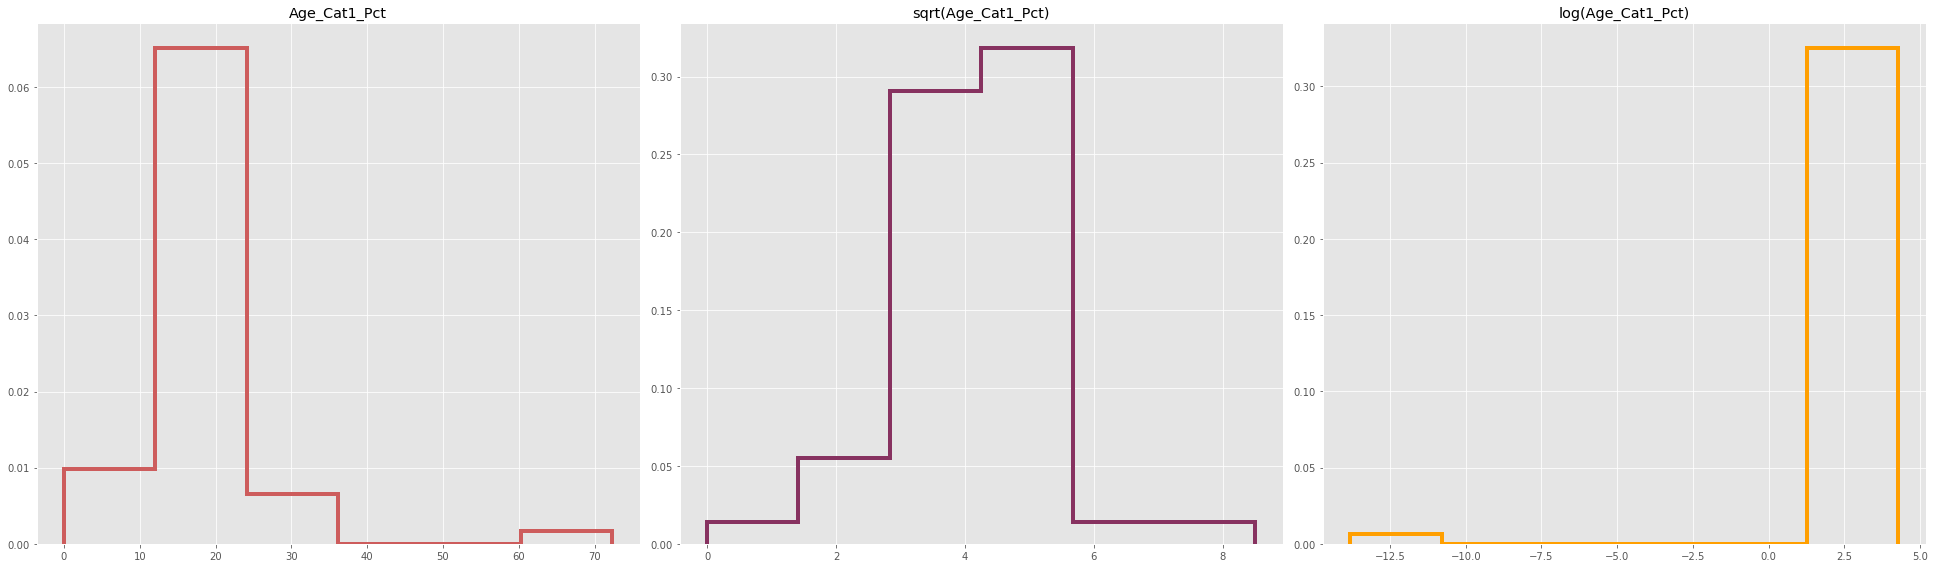

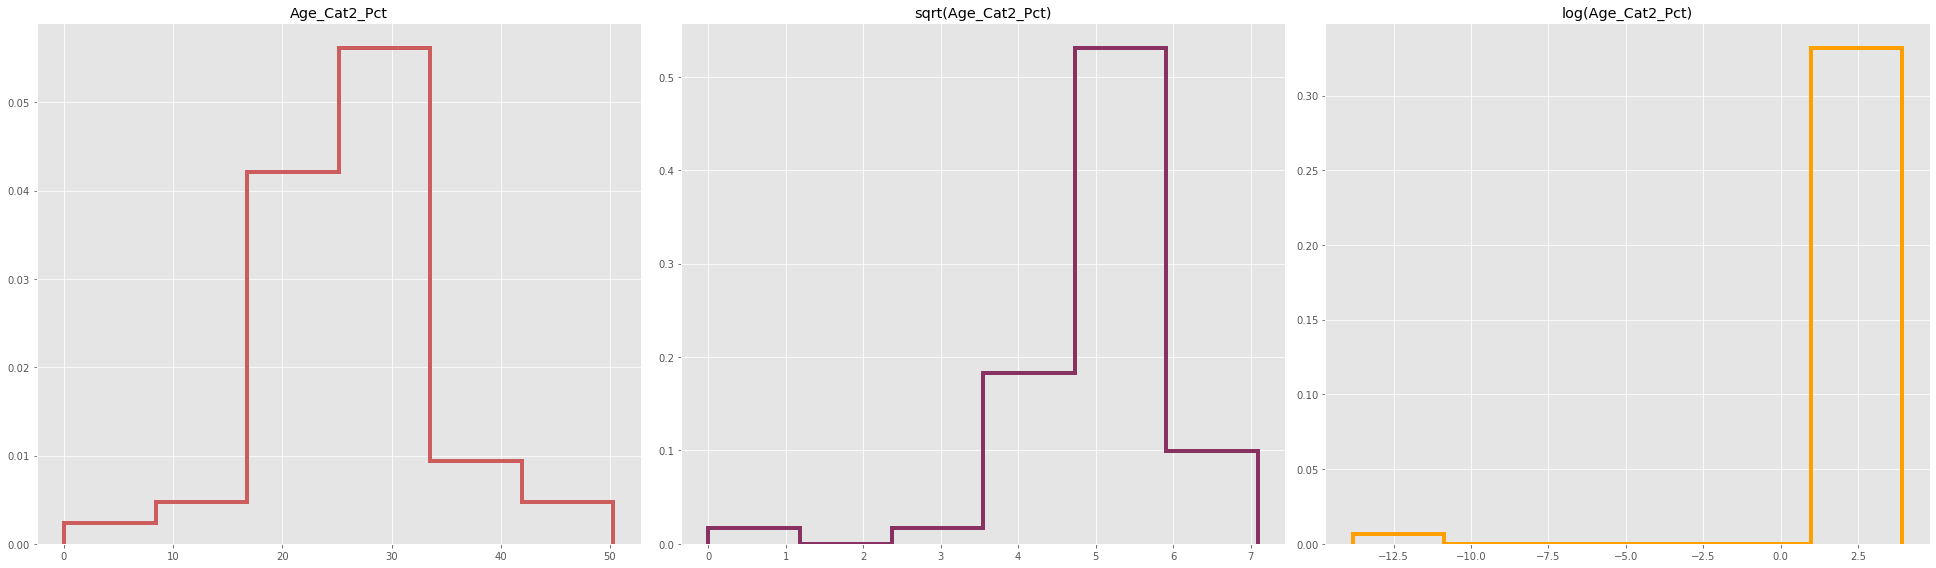

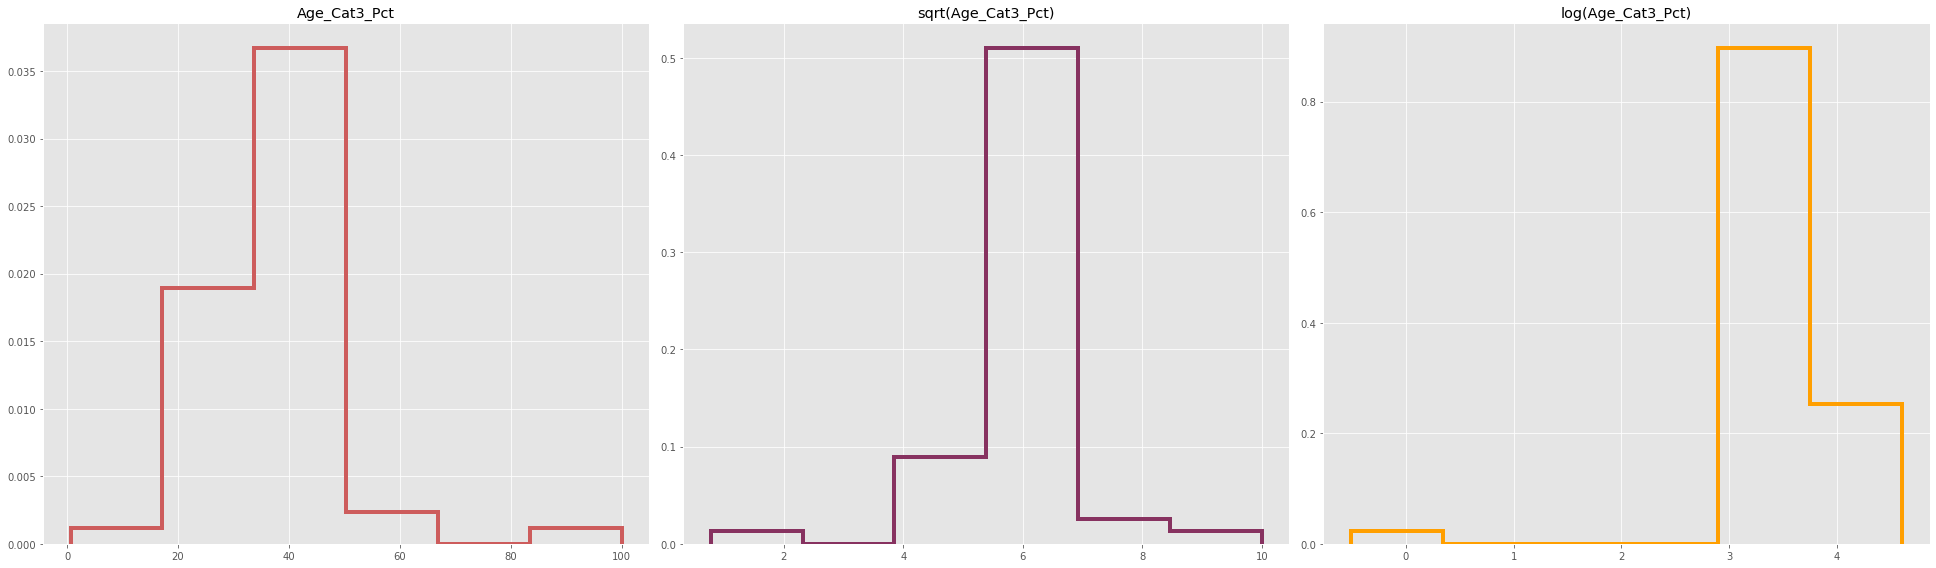

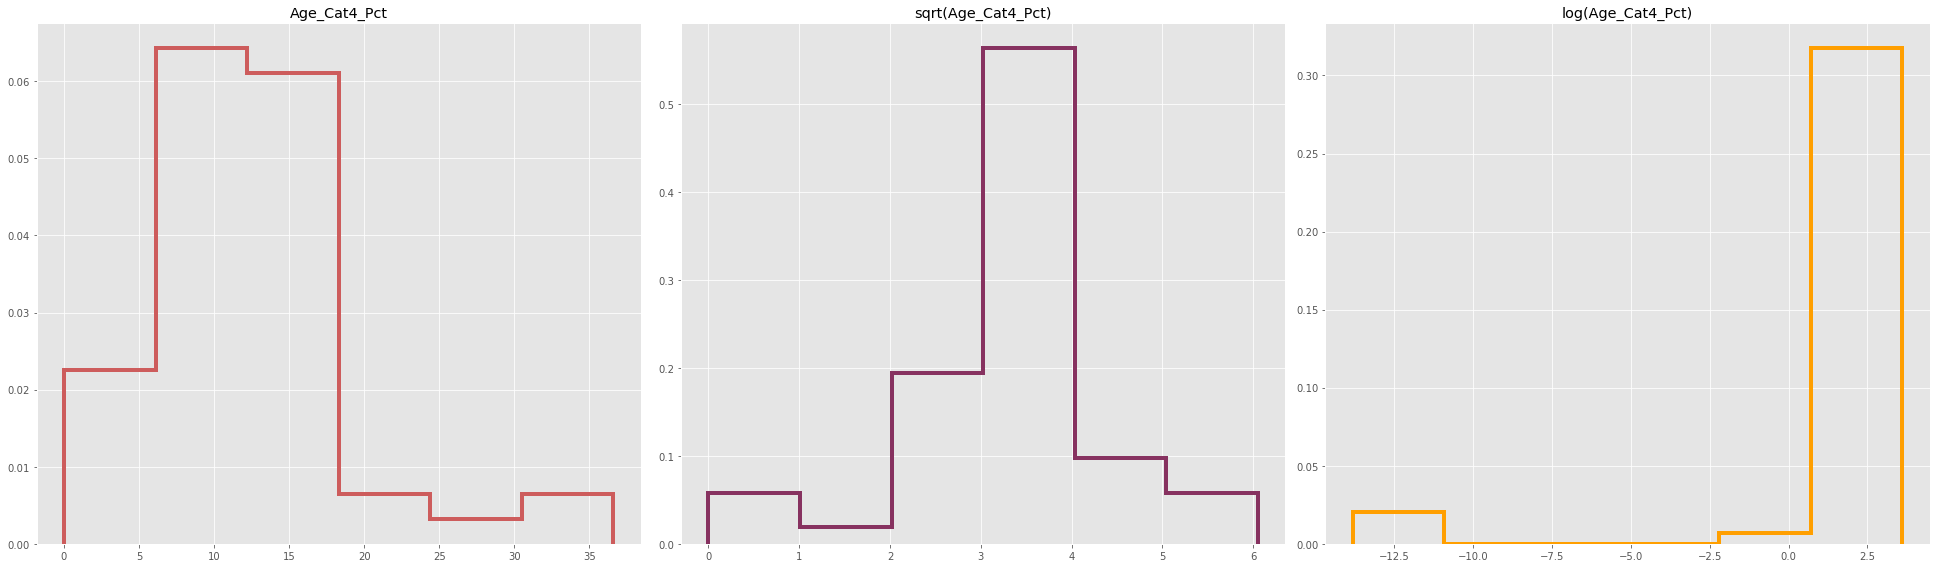

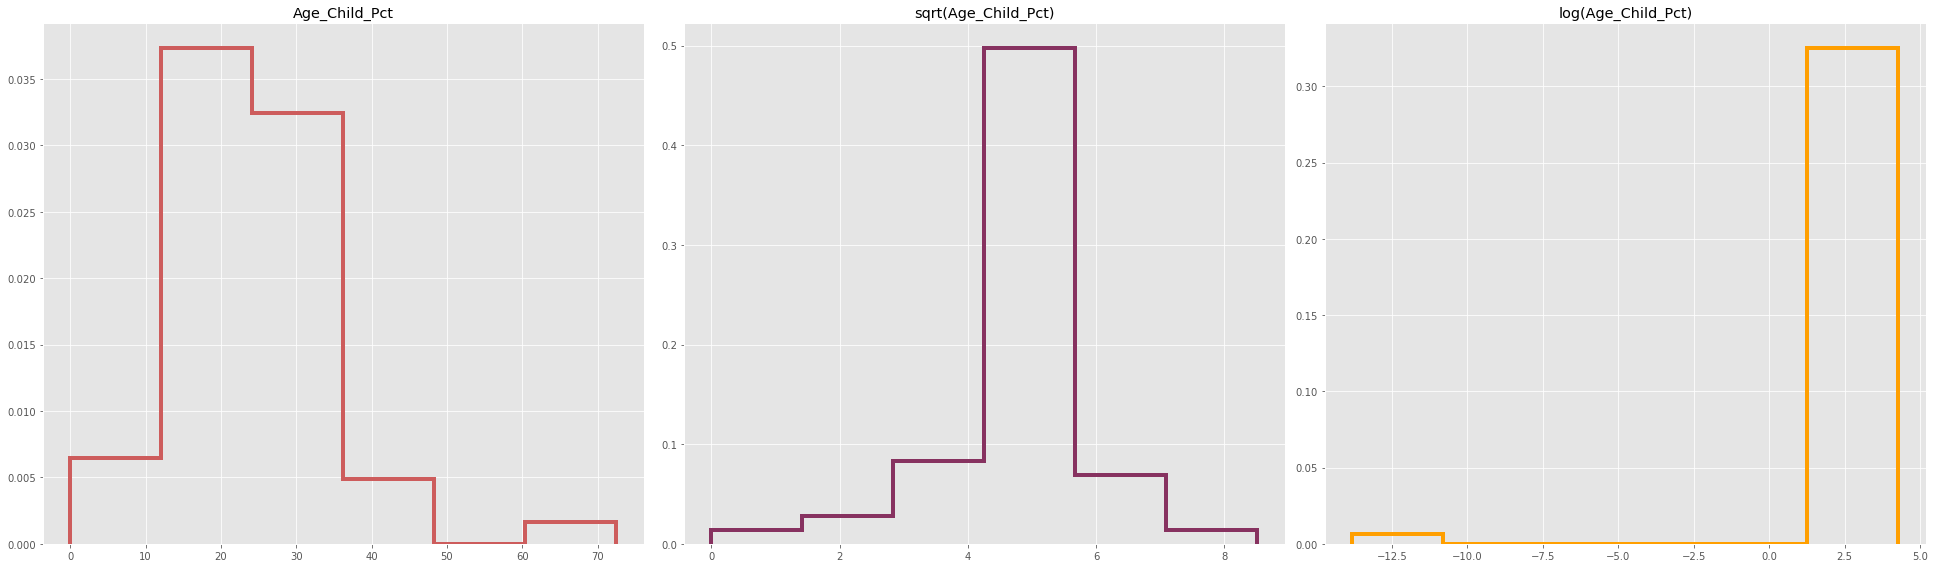

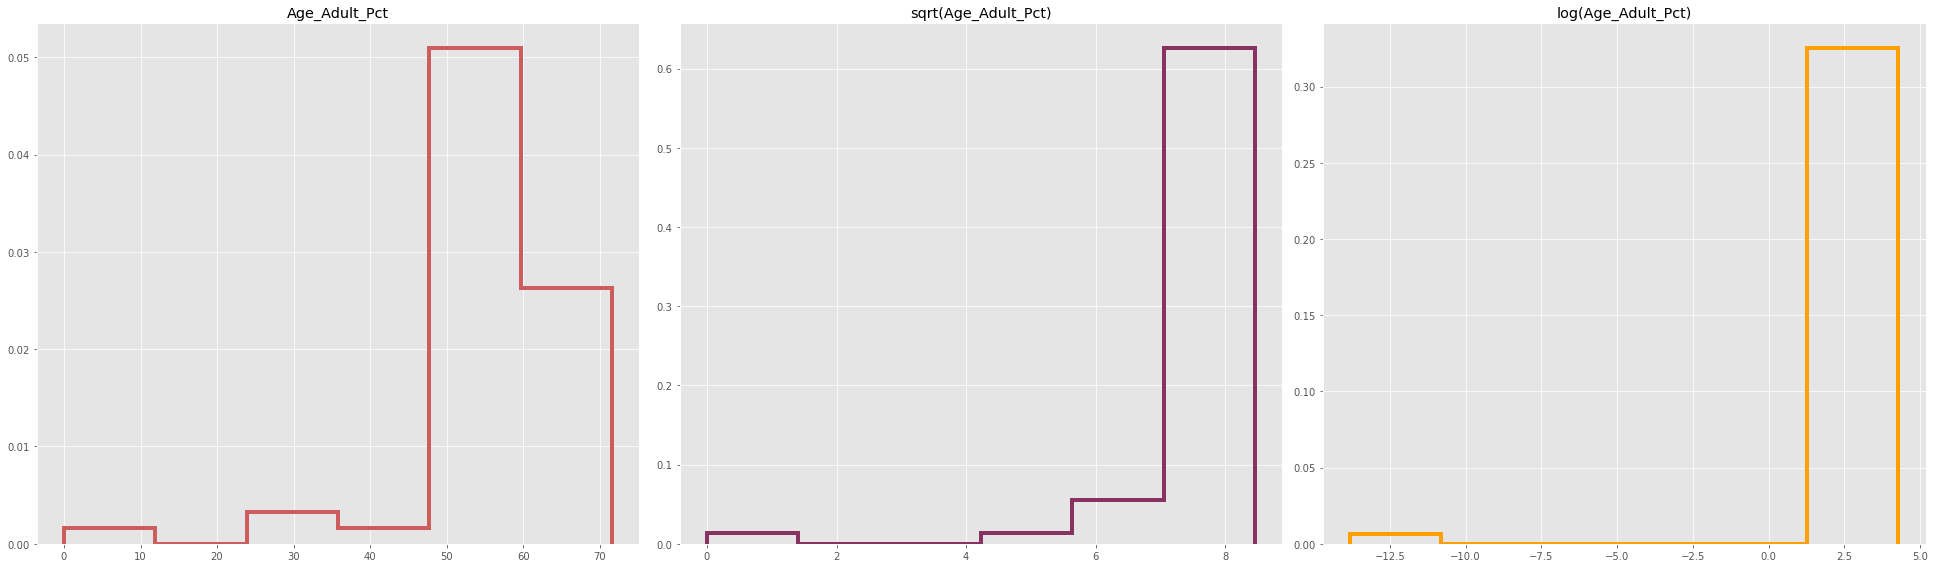

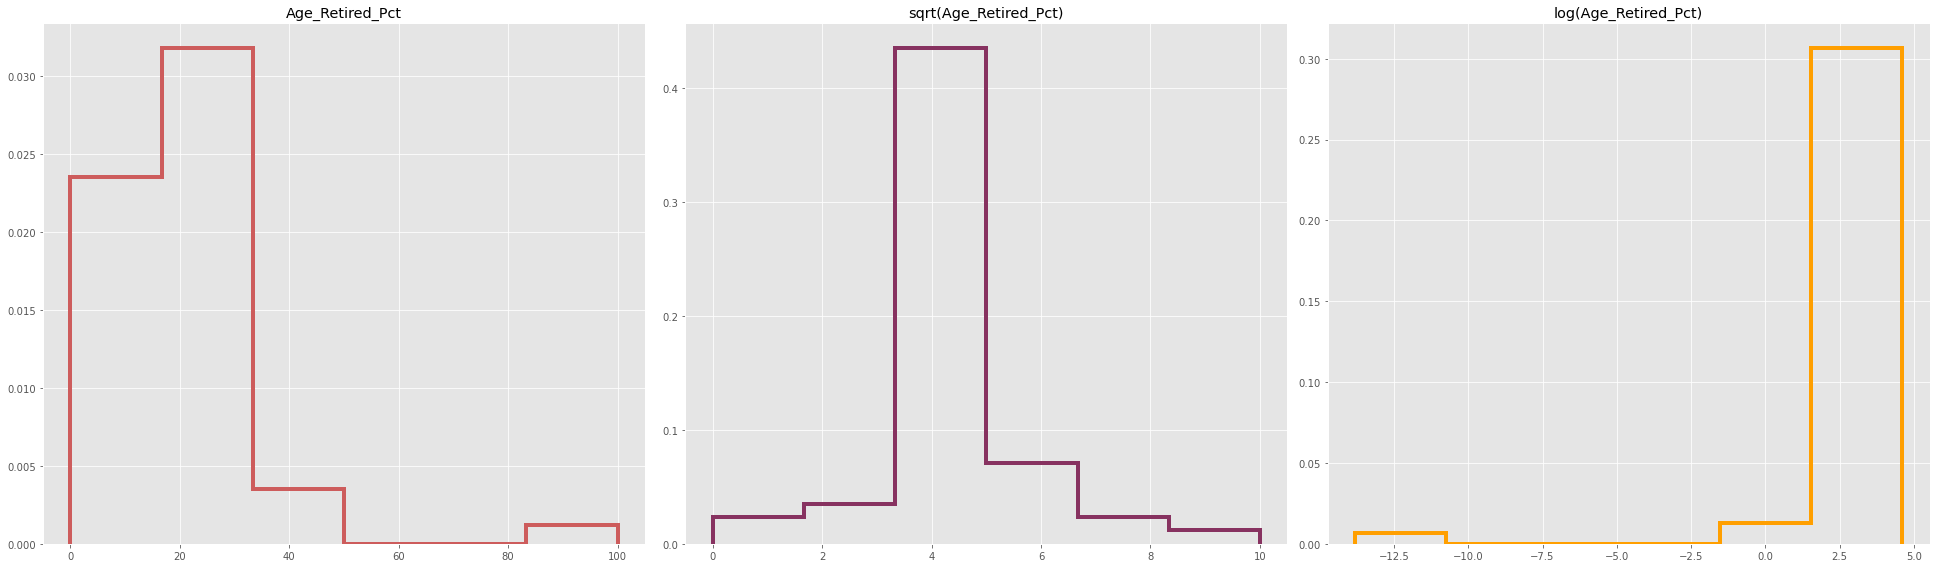

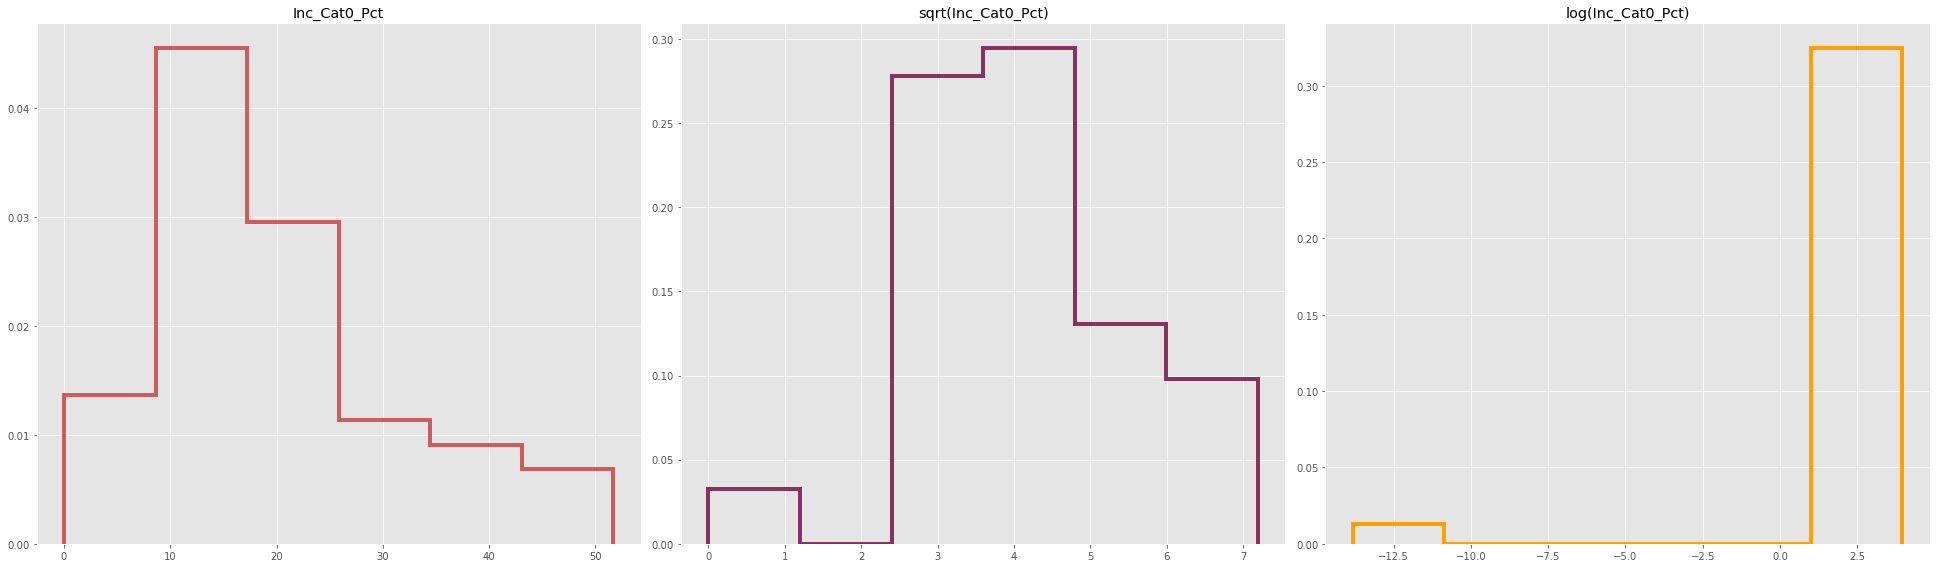

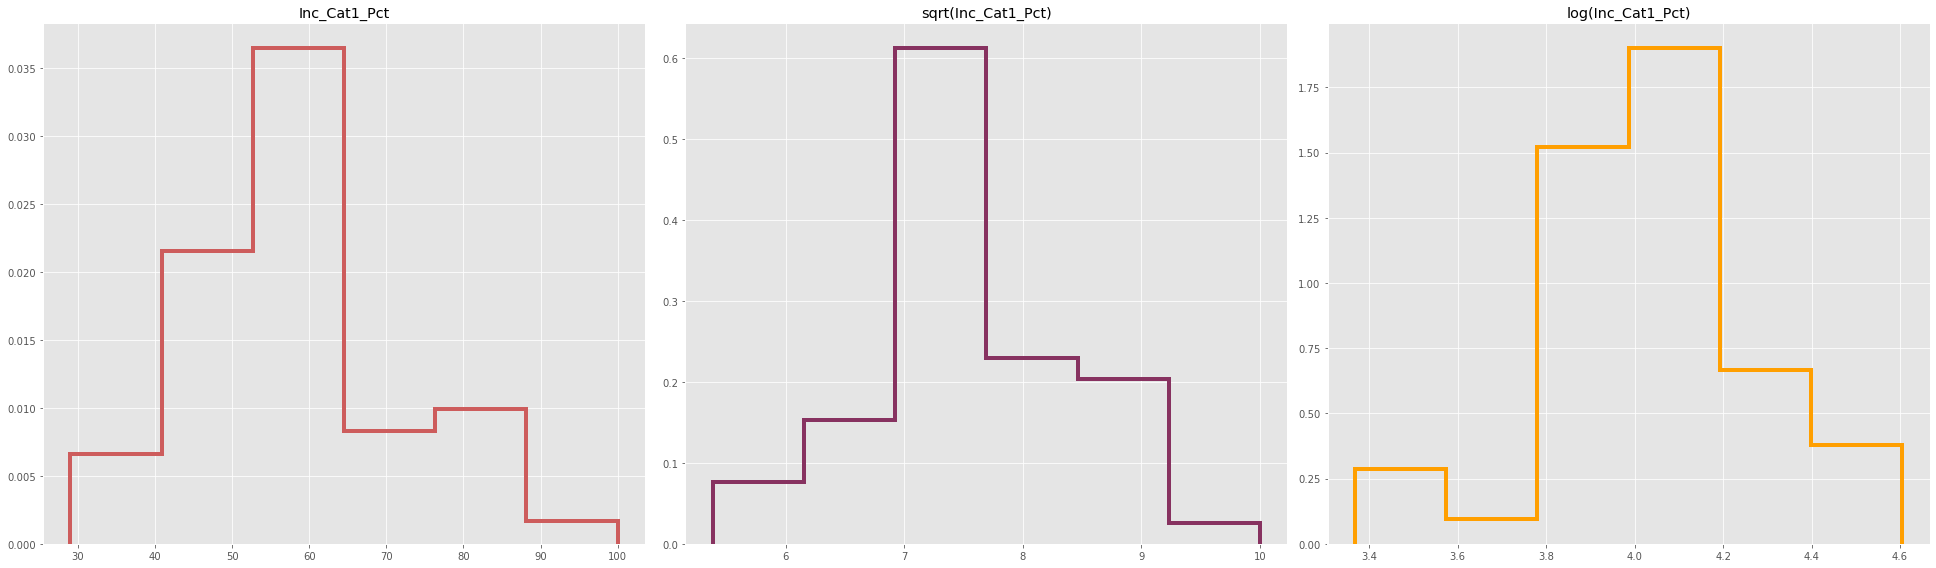

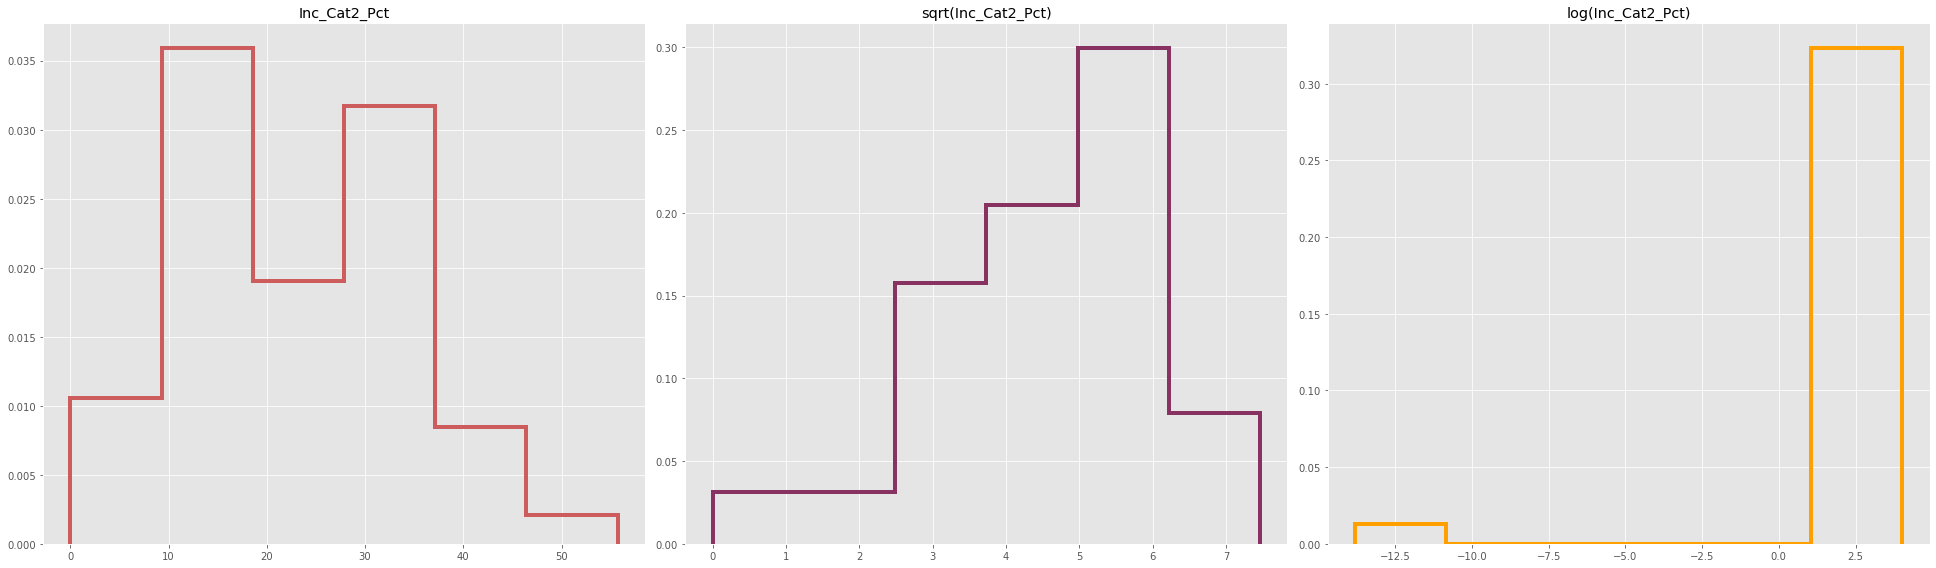

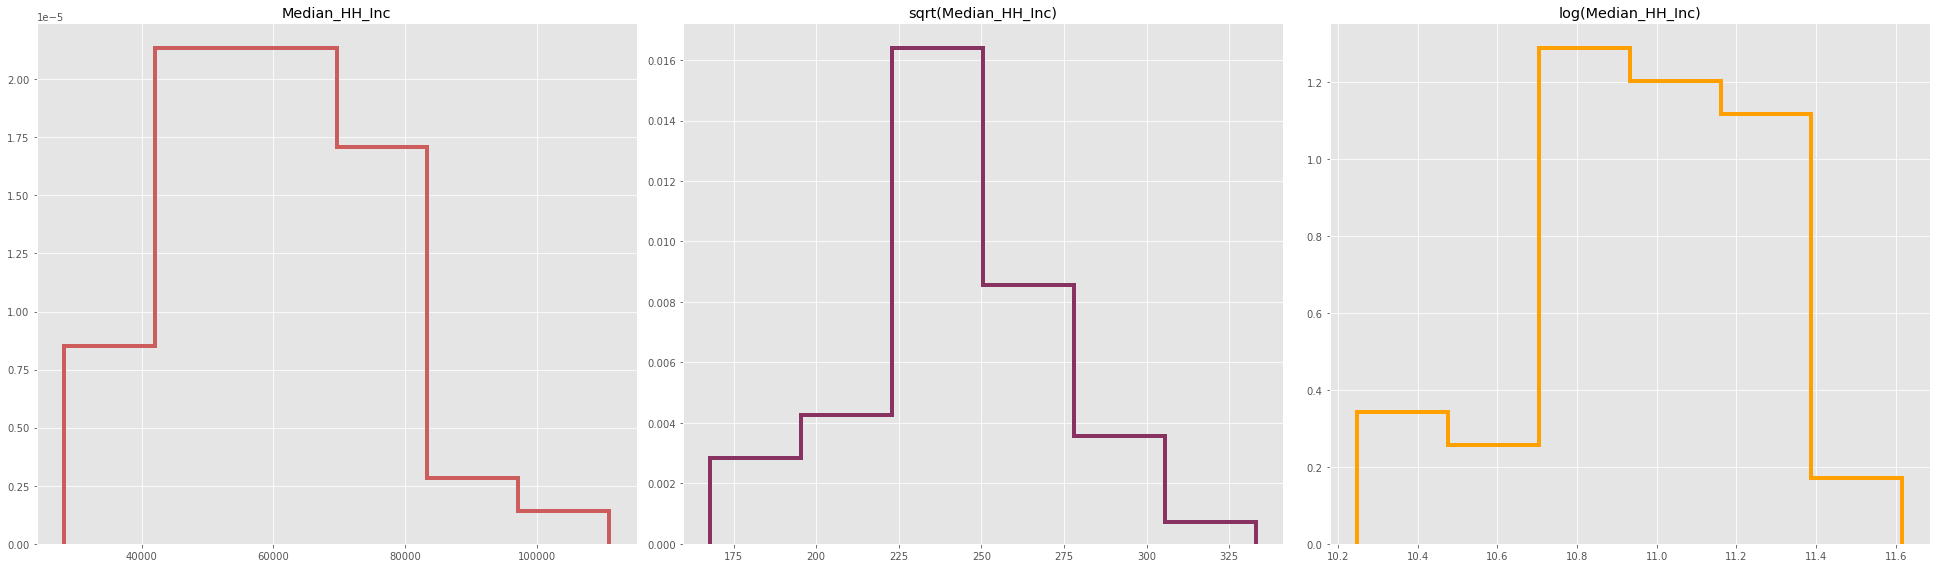

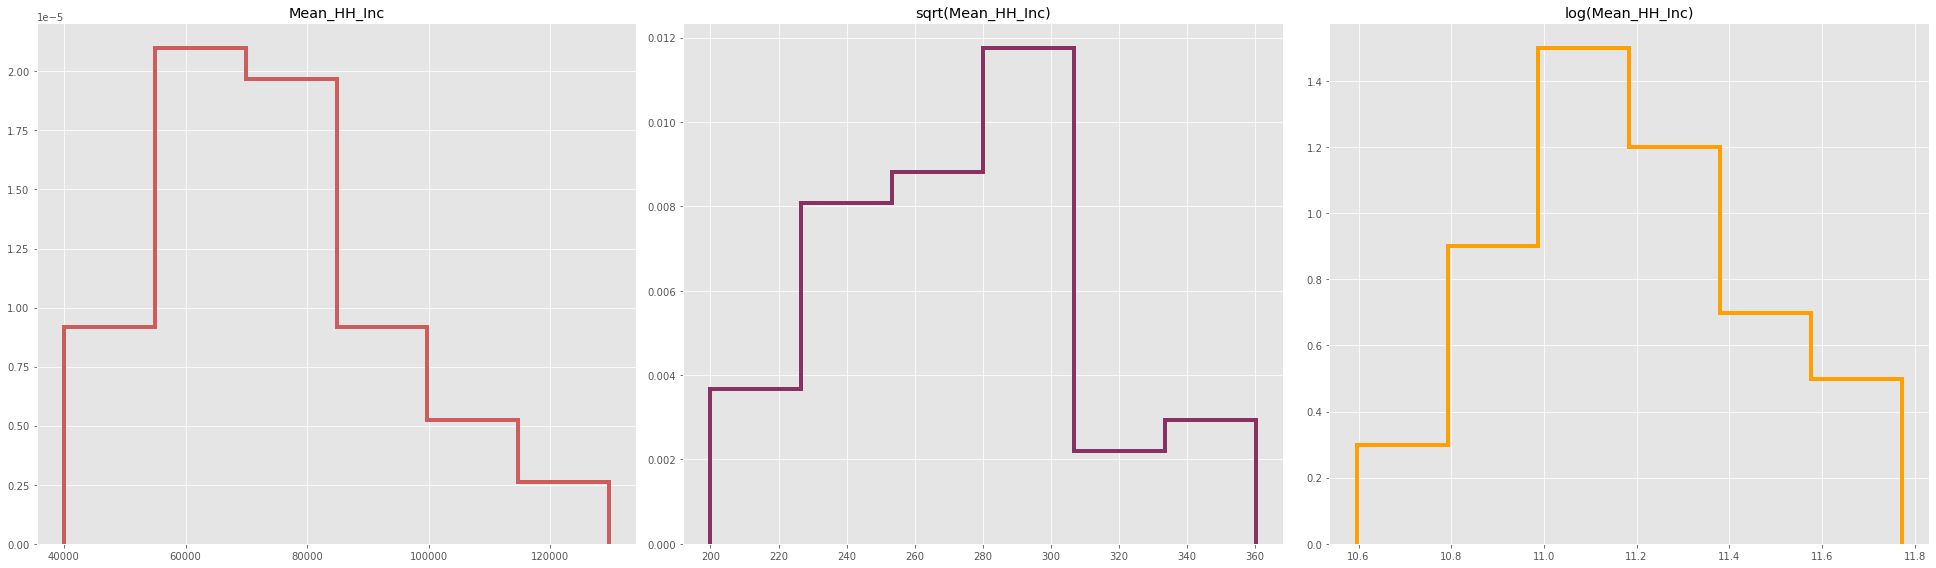

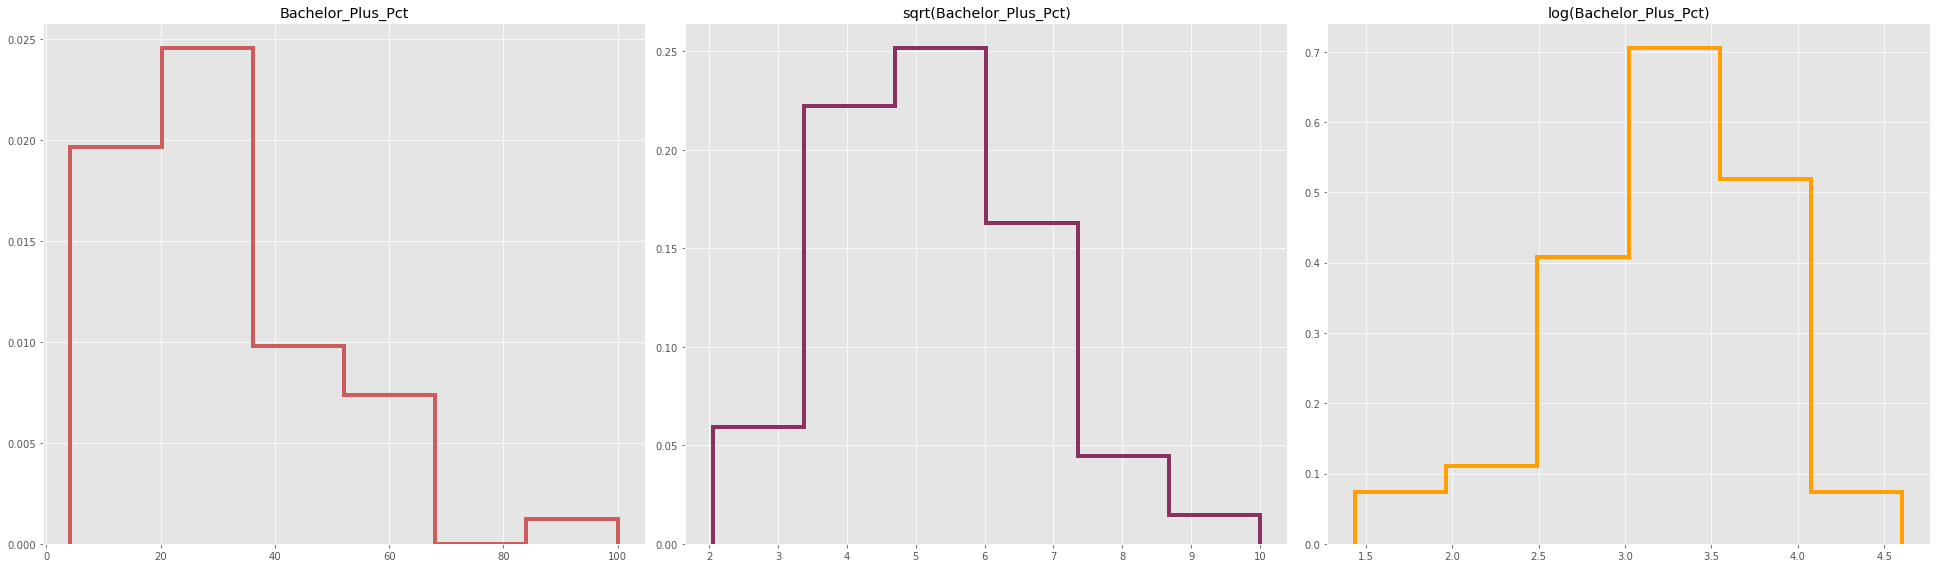

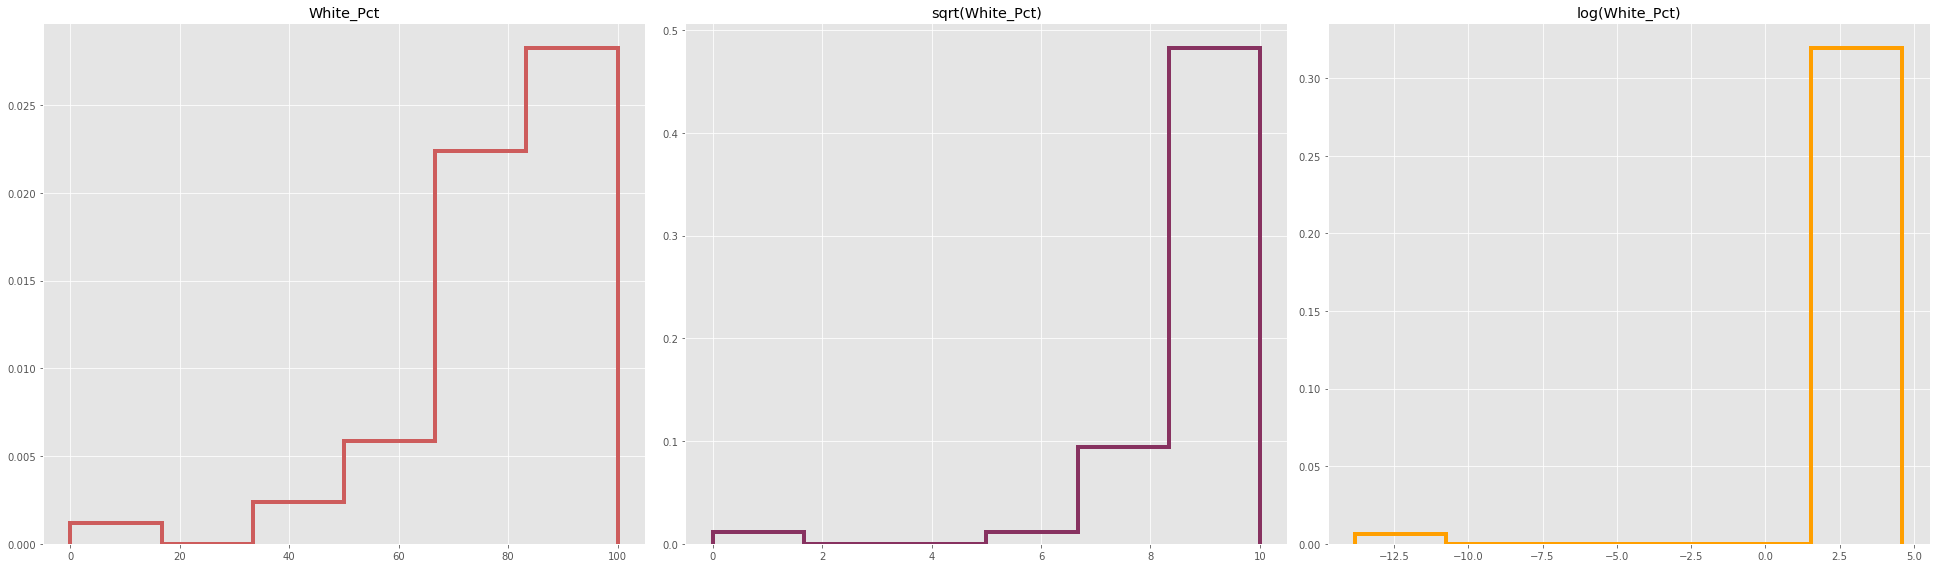

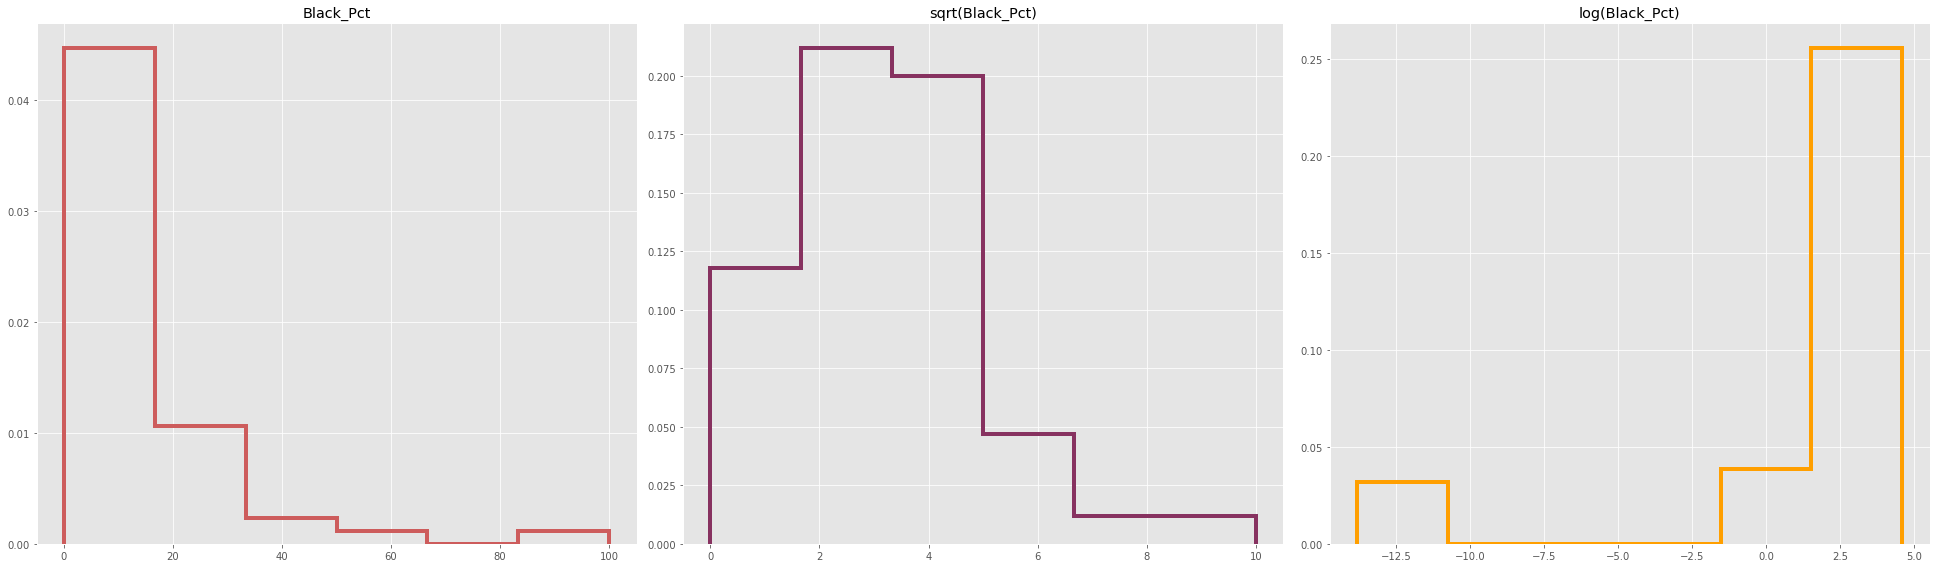

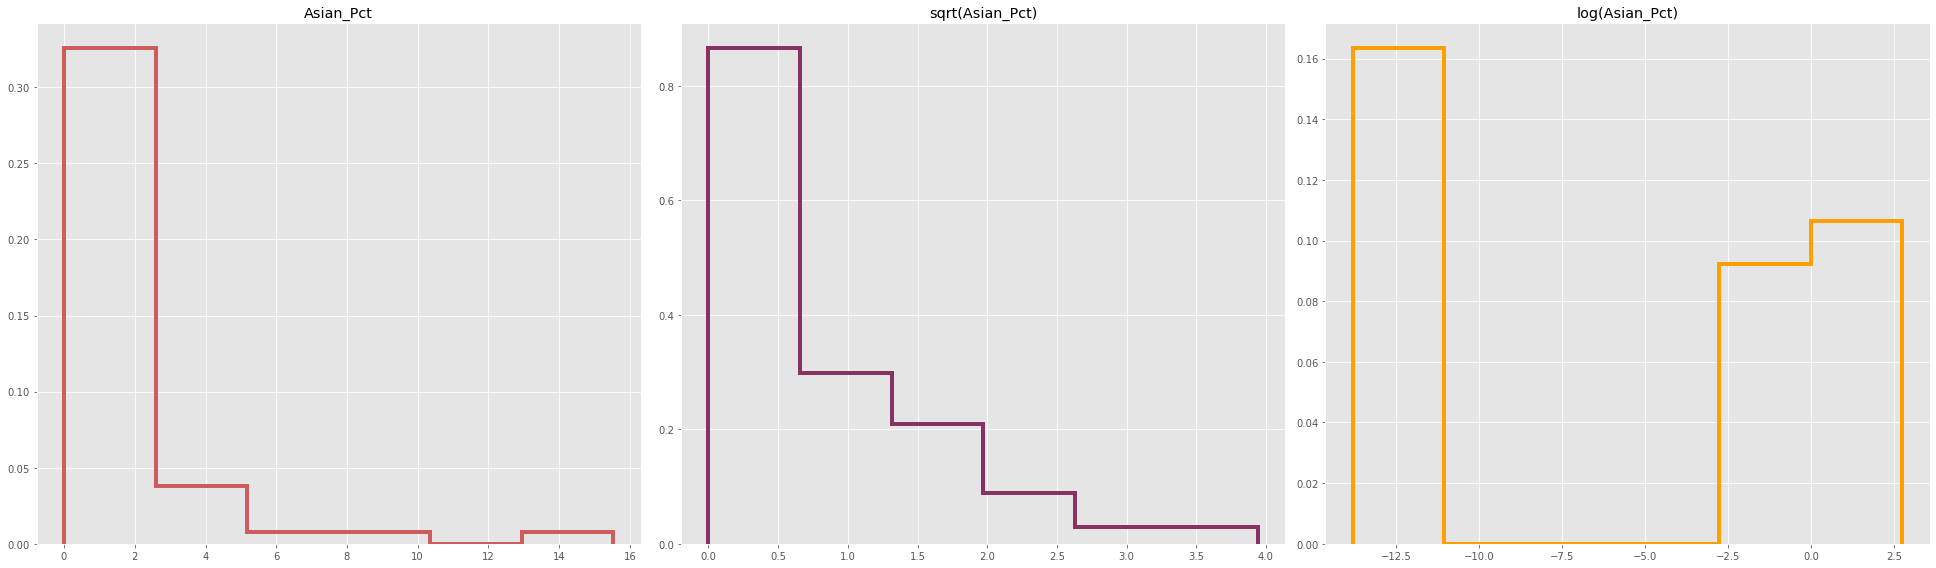

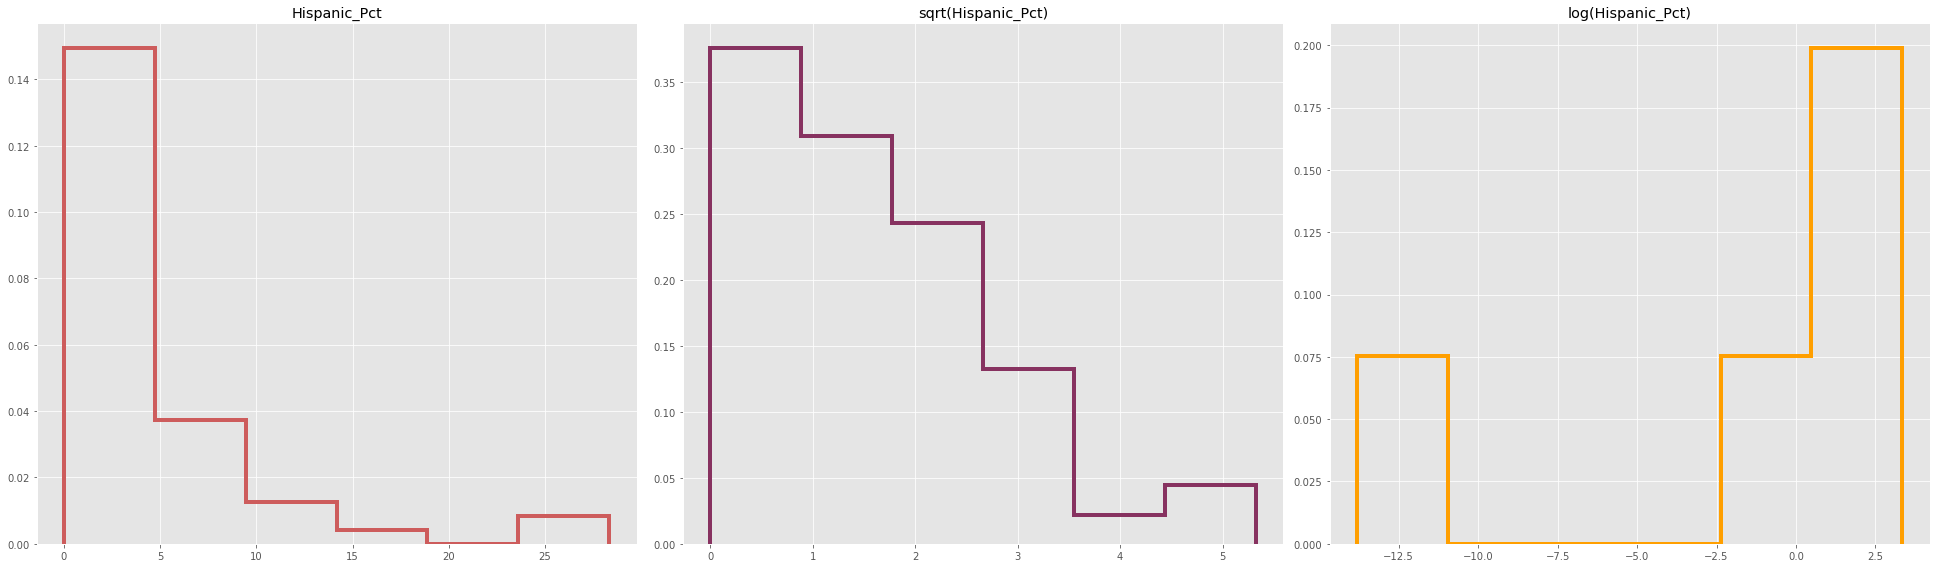

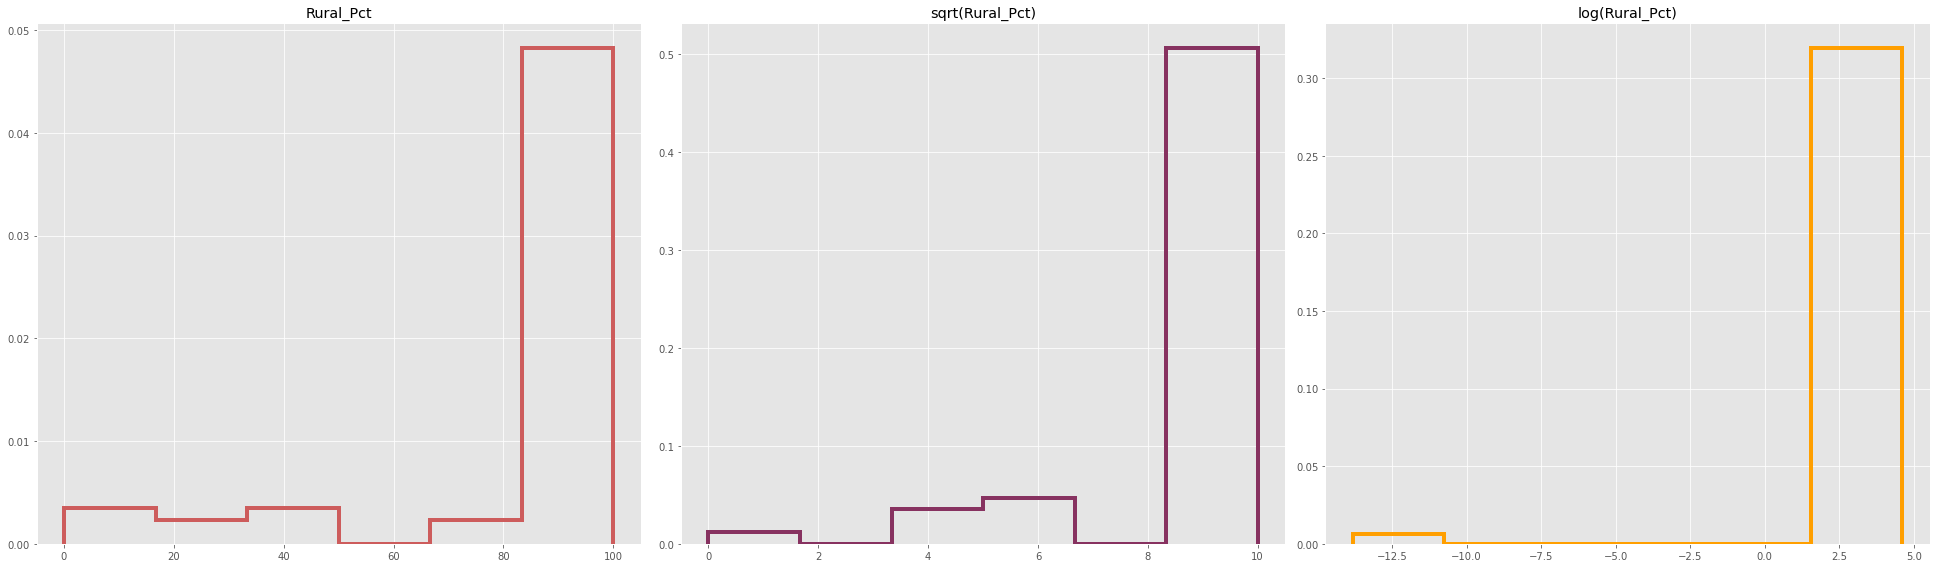

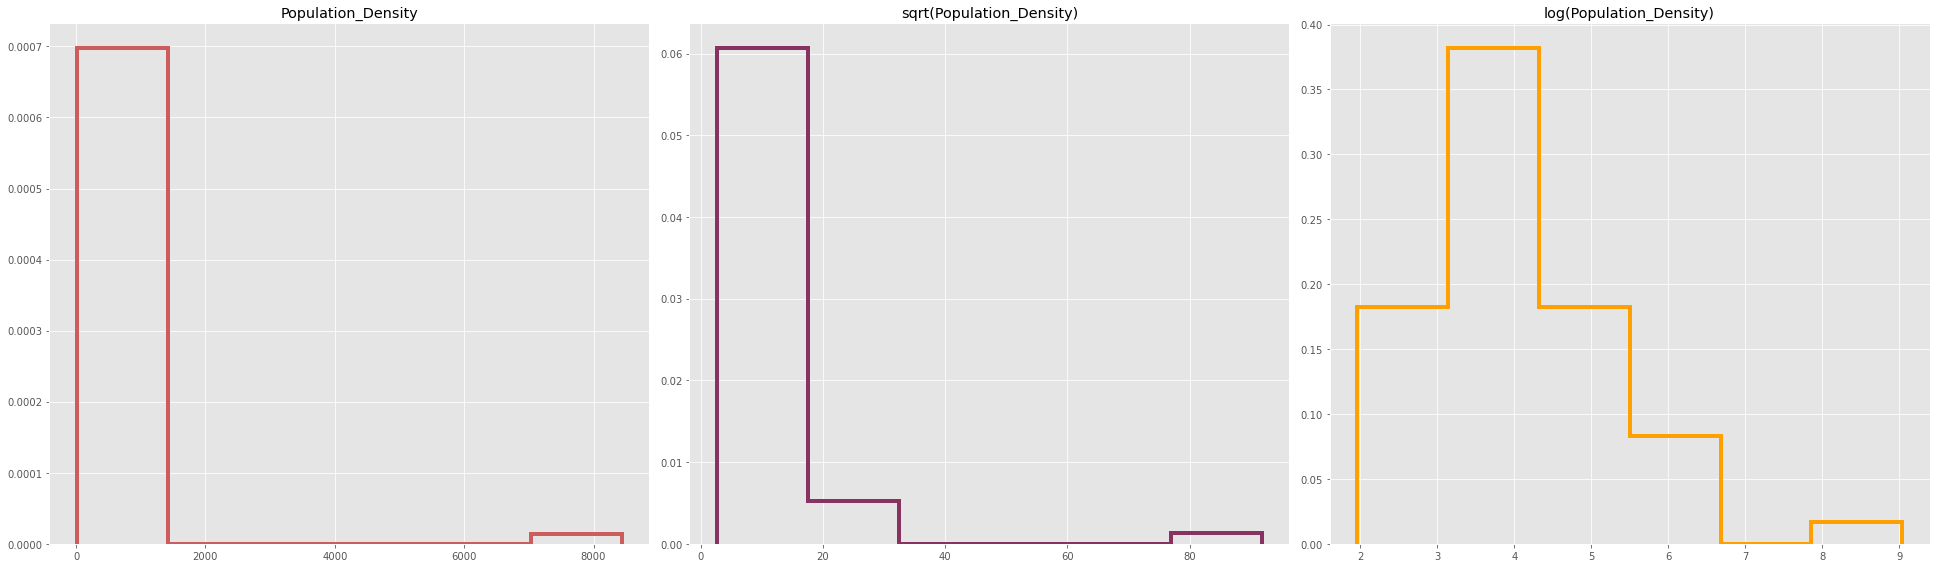

In [17]:
features = list(tjhd_df.columns)
for feature in features:
    width_ratios = [1, 1, 1]
    fig, subplot = plt.subplots(nrows=1, ncols=len(width_ratios), 
                                figsize=(27, 8),
                                gridspec_kw={'width_ratios': width_ratios})
    
    data = tjhd_df[feature].loc[~tjhd_df[feature].isnull()]
    subplot[0].hist(data, histtype='step', bins=num_bins, color='#CD5C5C', linewidth=4, density=True)
    subplot[0].set_title('%s' % feature)
    subplot[1].hist(np.sqrt(data), bins=num_bins, color='#873260', linewidth=4, histtype='step', density=True)
    subplot[1].set_title('sqrt(%s)' % feature)
    subplot[2].hist(np.log(data + 0.000001), bins=num_bins, color='#FF9F00', linewidth=4, histtype='step', density=True)
    subplot[2].set_title('log(%s)' % feature)
    plt.tight_layout()
    plt.show()

In [18]:
# Transform the features
# The following features are left untouched: Age_Cat2_Pct, Age_Adult_Pct, Inc_Cat2_Pct, 
#                                            Median_HH_Inc, White_Pct, Rural_Pct

# A Sqrt transformation is applied
for feature in ['Age_Cat0_Pct', 'Age_Cat1_Pct', 'Age_Cat3_Pct', 'Age_Cat4_Pct',
                'Age_Child_Pct', 'Age_Retired_Pct',
                'Inc_Cat0_Pct', 'Mean_HH_Inc',
                'Bachelor_Plus_Pct', 
                'Black_Pct', 'Asian_Pct', 'Hispanic_Pct']:
    tjhd_df[feature] = np.sqrt(tjhd_df[feature])

# A Log transformation is applied
for feature in ['Inc_Cat1_Pct', 'Population_Density']:
    tjhd_df[feature] = np.log(tjhd_df[feature])

Pairwise correlation is now performed on the remaining features.  Those pairs of features with a Pearson correlation > 0.75 are displayed.

Ignore large correlations between Age features.

Outlier ZCTAs are also identified.

In [19]:
def correlation_analysis(df, cols_to_use, abs_corr_threshold, color='#AAAAAA', output_path=None):
    """Plots a scatterplot for pairs of features where the 
    Pearson pairwise correlation is > 0.75.
    """  
    feature_corr = df[cols_to_use].corr()

    highly_correlated = []
    for col1, col2 in itr.combinations(cols_to_use, 2):
        if abs(feature_corr.loc[col1, col2]) > abs_corr_threshold:
            highly_correlated.append((col1, col2, feature_corr.loc[col1, col2]))
            plt.figure(figsize=(8, 6))
            plt.scatter(df[col1], df[col2], color=color)
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.annotate('Pearson Correlation: %.2f' % feature_corr.loc[col1, col2], 
                         xy=(0.1, 0.9), 
                         xycoords='axes fraction', 
                         fontsize='xx-large')
            plt.tight_layout()
            if output_path is not None:
                plt.savefig(output_path + 'high_corr_' + col1 + '_' + col2 + '.pdf')
            plt.show()

    for col1, col2, corr in highly_correlated:
        print(col1, col2, corr)

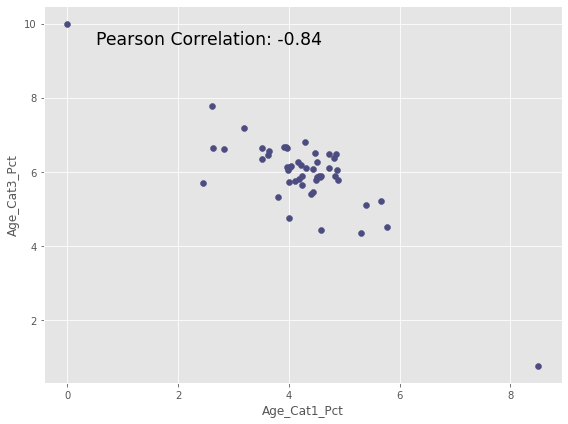

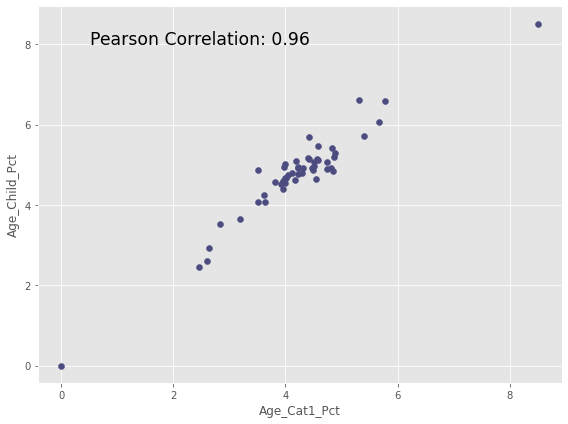

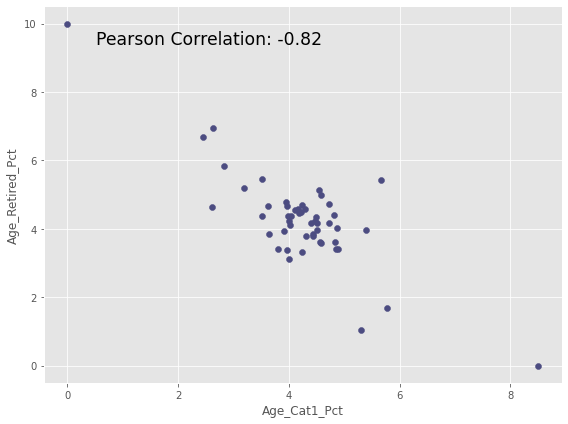

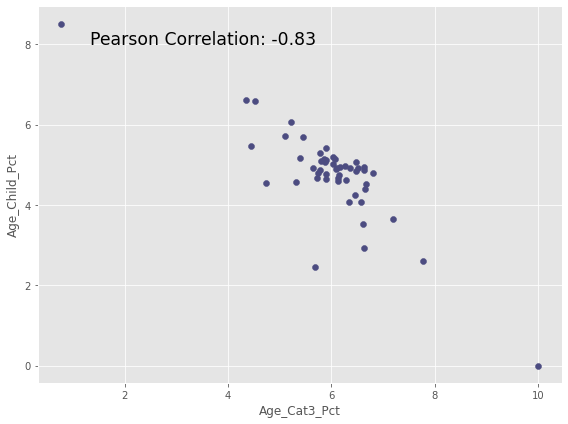

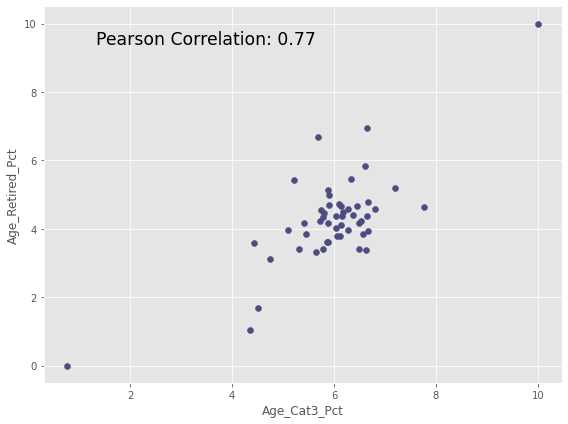

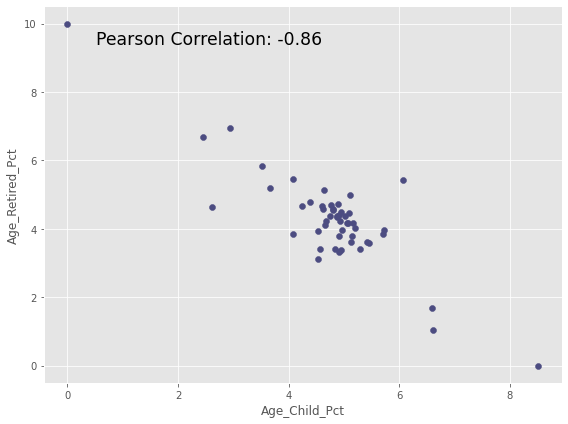

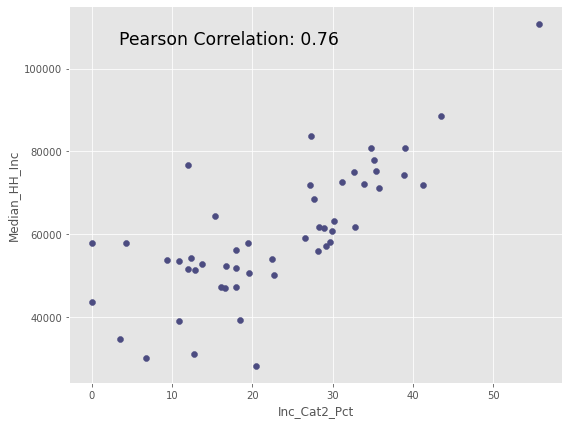

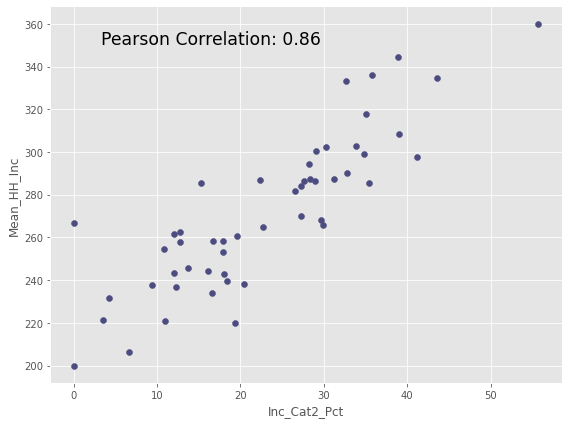

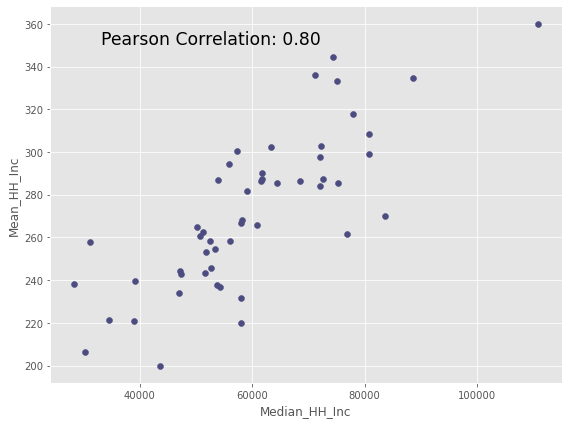

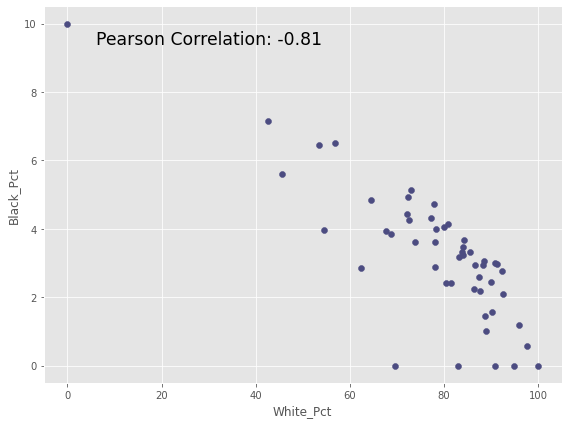

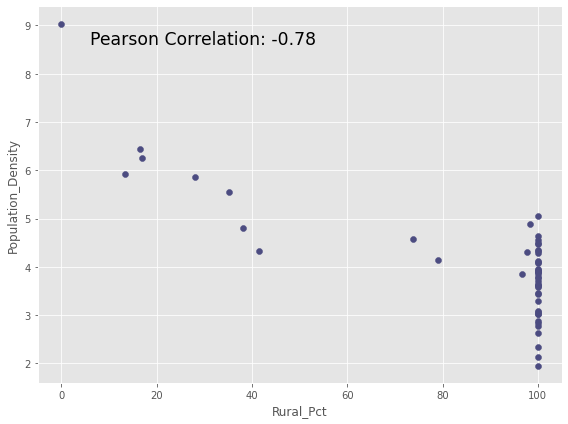

Age_Cat1_Pct Age_Cat3_Pct -0.8367780159261261
Age_Cat1_Pct Age_Child_Pct 0.9610239128951383
Age_Cat1_Pct Age_Retired_Pct -0.8188261693903229
Age_Cat3_Pct Age_Child_Pct -0.8346572969329857
Age_Cat3_Pct Age_Retired_Pct 0.7663438878027234
Age_Child_Pct Age_Retired_Pct -0.8636519930538605
Inc_Cat2_Pct Median_HH_Inc 0.759437142738974
Inc_Cat2_Pct Mean_HH_Inc 0.8627420136256847
Median_HH_Inc Mean_HH_Inc 0.7964609425736013
White_Pct Black_Pct -0.8147675819248793
Rural_Pct Population_Density -0.7811130599947762


In [20]:
correlation_analysis(tjhd_df, features, 0.75, color='#4c4c81')

Remove outliers:

White_Pct < 20: Corresponds to ZCTA 24581

Rural_Pct == 0: Corresponds to ZCTA 22904

Perform correlation analysis with new dataset.

In [21]:
outlier_mask = (tjhd_df['White_Pct'] < 20) | (tjhd_df['Rural_Pct'] == 0)
outliers = tjhd_df.loc[outlier_mask]
outliers

,Age_Cat0_Pct,Age_Cat1_Pct,Age_Cat2_Pct,Age_Cat3_Pct,Age_Cat4_Pct,Age_Child_Pct,Age_Adult_Pct,Age_Retired_Pct,Inc_Cat0_Pct,Inc_Cat1_Pct,Inc_Cat2_Pct,Median_HH_Inc,Mean_HH_Inc,Bachelor_Plus_Pct,White_Pct,Black_Pct,Asian_Pct,Hispanic_Pct,Rural_Pct,Population_Density
ZCTA,,,,,,,,,,,,,,,,,,,,
22904,0.447214,8.502941,26.9,0.774597,0.0,8.514693,27.5,0.0,7.190271,3.367296,19.4,57981.0,219.831754,7.021396,62.395188,2.844878,3.940868,2.645682,0.0,9.040794
24581,0.000000,0.000000,0.0,10.000000,0.0,0.000000,0.0,10.0,0.000000,4.605170,0.0,57981.0,266.801424,10.000000,0.000000,10.000000,0.000000,0.000000,100.0,1.954165


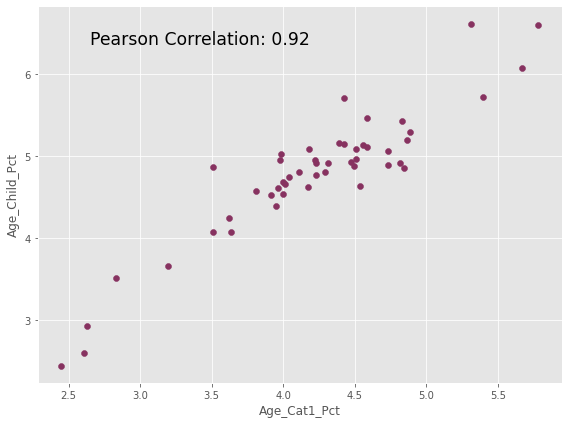

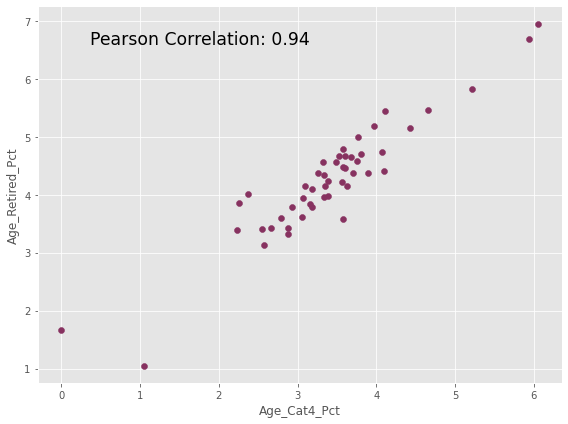

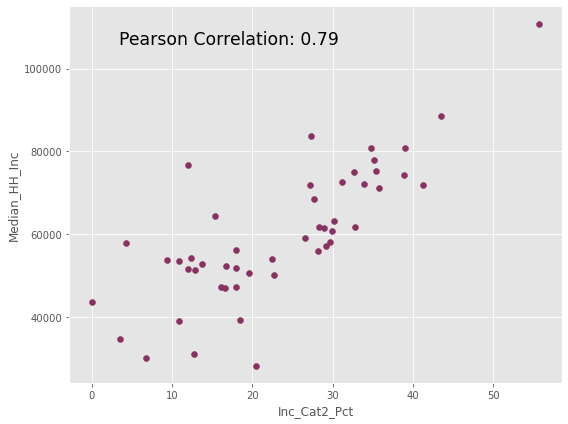

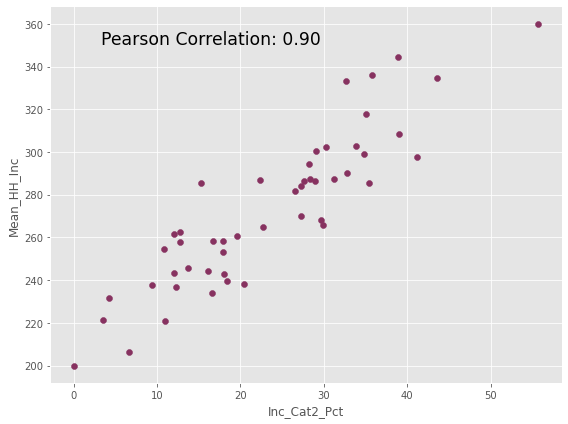

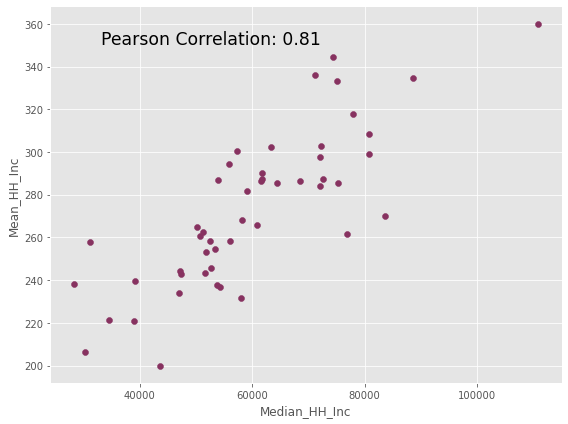

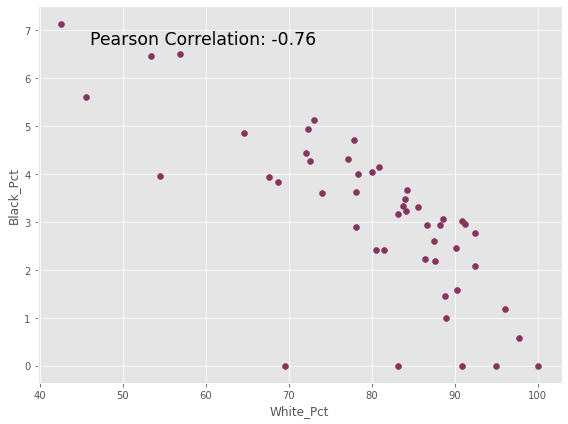

Age_Cat1_Pct Age_Child_Pct 0.9231090147334535
Age_Cat4_Pct Age_Retired_Pct 0.9365720308215567
Inc_Cat2_Pct Median_HH_Inc 0.7850957673102429
Inc_Cat2_Pct Mean_HH_Inc 0.901854106919629
Median_HH_Inc Mean_HH_Inc 0.8105306431902061
White_Pct Black_Pct -0.7635145808569774


In [22]:
non_outlier_tjhd_df = tjhd_df.loc[~tjhd_df.index.isin(outliers.index)]
correlation_analysis(non_outlier_tjhd_df, features, 0.75, color='#873260')

In [23]:
non_outlier_tjhd_df.shape

(49, 20)

Remove White_Pct due to it's correlation with Black_Pct.

Remove Median_HH_Inc and Mean_HH_Inc due to their correlation with Inc_Cat2_Pct.

Save the features for use in the cluster analysis.

In [24]:
usable_features = ['Age_Cat0_Pct', 'Age_Cat1_Pct', 'Age_Cat2_Pct', 'Age_Cat3_Pct', 'Age_Cat4_Pct',
                   'Age_Child_Pct', 'Age_Adult_Pct', 'Age_Retired_Pct',
                   'Inc_Cat0_Pct', 'Inc_Cat1_Pct', 'Inc_Cat2_Pct',
                   'Bachelor_Plus_Pct', 
                   'Black_Pct', 'Asian_Pct', 'Hispanic_Pct',
                   'Rural_Pct',
                   'Population_Density']

non_outlier_tjhd_df[usable_features].to_csv('output/non_outlier_TJHD_ZCTA_transformed_features.csv')